In [6]:
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

# Функция для расчета R²
def rSquar(j, y, X):
    return sm.OLS(y, sm.add_constant(X.iloc[:,:j])).fit().rsquared

plt.rcParams['figure.figsize'] = (8, 6)
data = pd.read_csv("test_sample.csv")
np.random.seed(12345678)

# Подготовка данных
X = pd.DataFrame(data.iloc[:, 1:])
Y = pd.DataFrame(data.iloc[:, 0])

# Шаг 1: Нахождение n_orig (минимальное количество предикторов для R² > 0.9)
n_orig = 0
for j in range(2, 492):
    r2 = rSquar(j, Y, X)
    if r2 >= 0.9:
        n_orig = j
        print(f"Step 1: n_orig = {n_orig} (R² = {r2:.5f})")
        break

# Шаг 2: PCA анализ
nFactors = 491
xPCA = PCA(n_components=nFactors)
xPCA.fit(X)
factorScores = pd.DataFrame(xPCA.transform(X),
                    columns=[f"PC{i+1}" for i in range(nFactors)])

Step 1: n_orig = 349 (R² = 0.90413)


Step 2: n_PCA = 146 (R² = 0.90030)

Final Results:
Model dimensionality reduction: 203
Determination coefficient with PCA: 0.90030


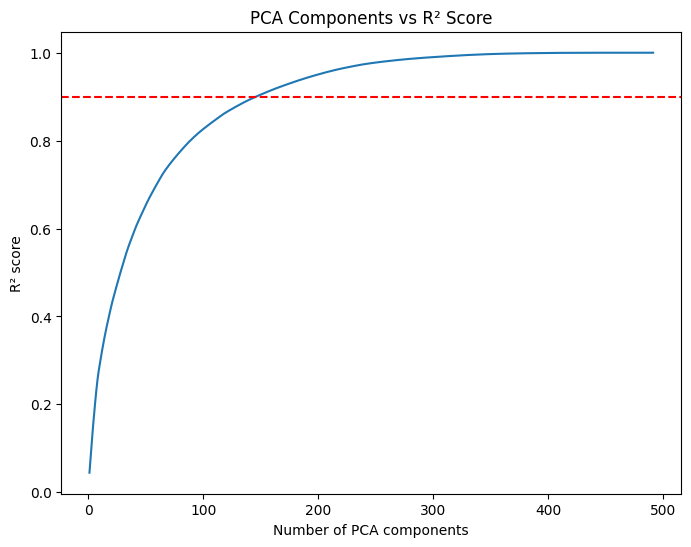

In [7]:
def rel_imp_me(X, y):
    names = X.columns
    res = pd.DataFrame(columns=['first'], index=names)
    res['first'] = X.apply(lambda x: np.corrcoef(y.values.flatten(), x)[0,1]**2, axis=0)
    return res

# Расчет важности PCA компонент
metrics_PCA = rel_imp_me(factorScores, Y['Y'])
first_PCA_rank = metrics_PCA['first'].rank(ascending=False, method='first')

# Сортировка компонент по важности
orderedFactors = factorScores[first_PCA_rank.sort_values().index]

# Поиск n_PCA
n_PCA = 0
for j in range(1, 492):
    r2 = rSquar(j, Y, orderedFactors)
    if r2 >= 0.9:
        n_PCA = j
        print(f"Step 2: n_PCA = {n_PCA} (R² = {r2:.5f})")
        break

# Расчет итоговых значений
dimensionality_reduction = n_orig - n_PCA
final_r2 = rSquar(n_PCA, Y, orderedFactors)

print("\nFinal Results:")
print(f"Model dimensionality reduction: {dimensionality_reduction}")
print(f"Determination coefficient with PCA: {final_r2:.5f}")

# Визуализация
plt.plot(range(1, 492), [rSquar(j, Y, orderedFactors) for j in range(1, 492)])
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel('Number of PCA components')
plt.ylabel('R² score')
plt.title('PCA Components vs R² Score')
plt.show()